[필사 원본](https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition)

## 라이브러리 & 데이터 불러오기

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Essentials
import os
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [63]:
PATH = '/content/drive/MyDrive/house-prices-advanced-regression-techniques'

data = os.listdir(PATH)
data

['train.csv', 'test.csv', 'sample_submission.csv', 'data_description.txt']

In [64]:
train = pd.read_csv(f"{PATH}/{data[0]}")
test = pd.read_csv(f"{PATH}/{data[1]}")

In [65]:
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [66]:
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 결측치 조회

In [67]:
# 결측치 개수 TOP10
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [68]:
test.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

## SalePrice: the variable we're trying to predict

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


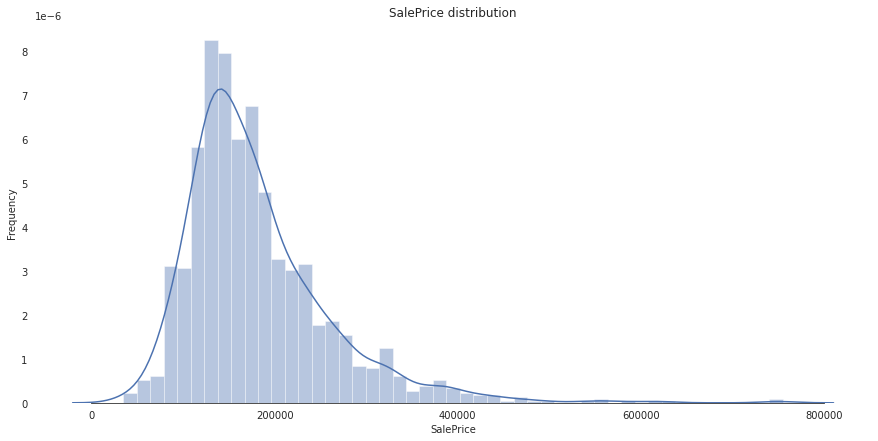

In [69]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(15, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")


# 그래프의 테두리 제거
# Remove the top and right spines from plot(s).
# 파라미터를 통해 왼쪽도 제거
sns.despine(trim=True, left=True)
plt.show()

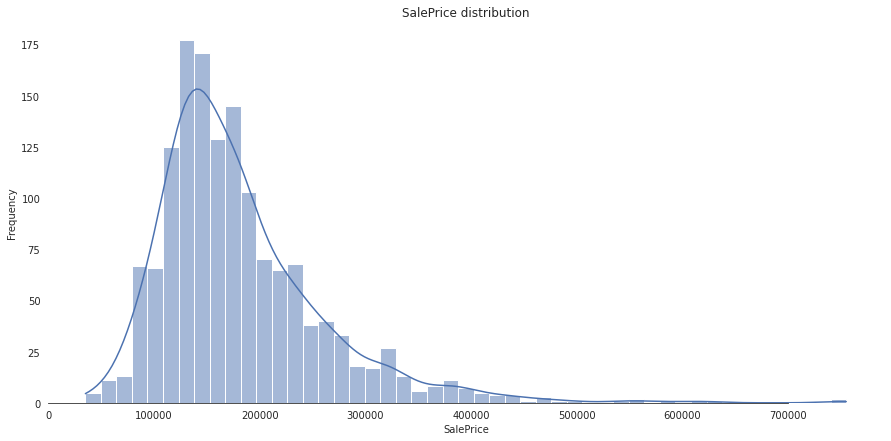

In [70]:
# 사라질거란 경고문구로 인해 histplot을 이용해 똑같이 구현
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(15, 7))

sns.histplot(train['SalePrice'], color="b", kde=True);

ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [71]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [72]:
# Skew and kurt
skew = train['SalePrice'].skew()
kurt = train['SalePrice'].kurt()

print(f"Skewness: {skew:.6f}")
print(f"Kurtosis: {kurt:.6f}")

Skewness: 1.882876
Kurtosis: 6.536282


## Features: a deep dive
Let's visualize some of the features in the dataset

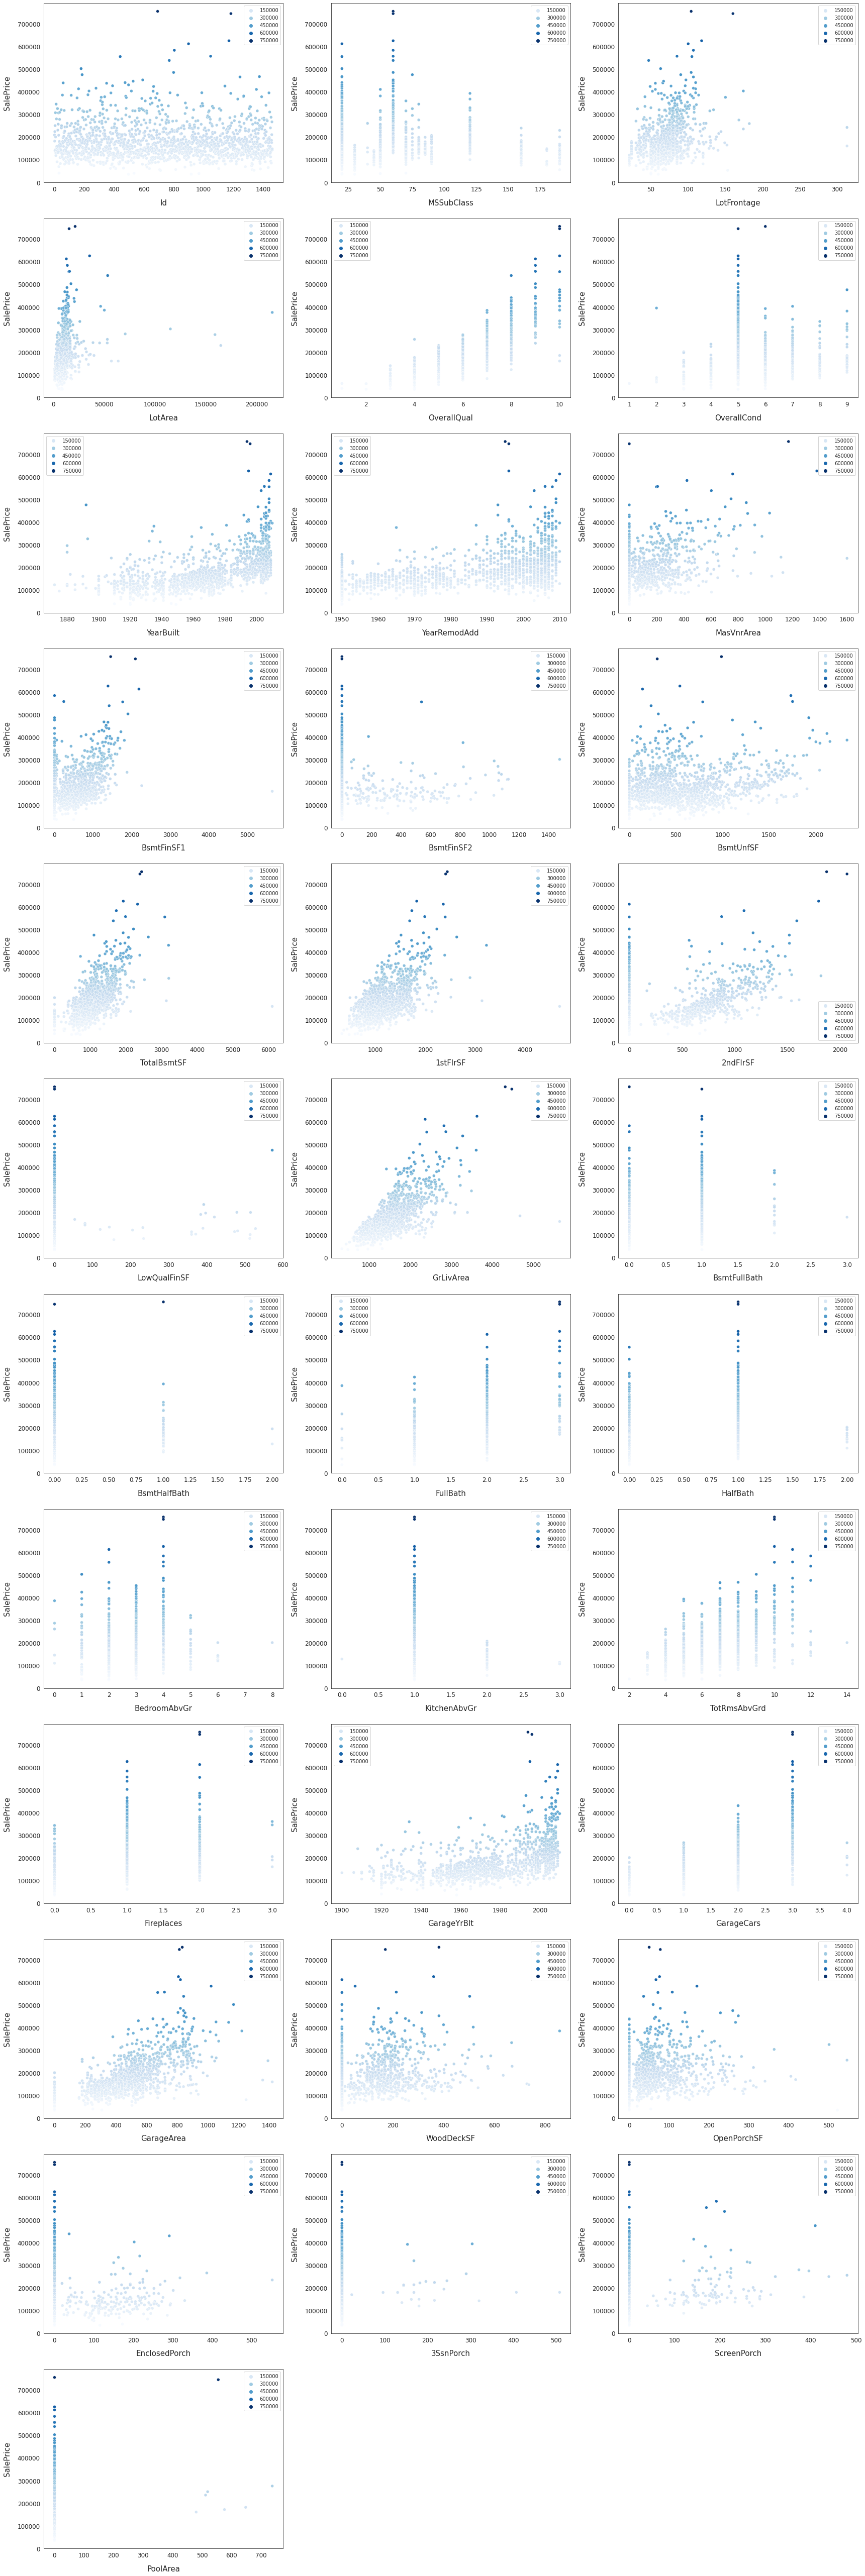

In [73]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)

# print(numeric) 
# print(len(numeric))

# visualising some more outliers in the data values
# fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

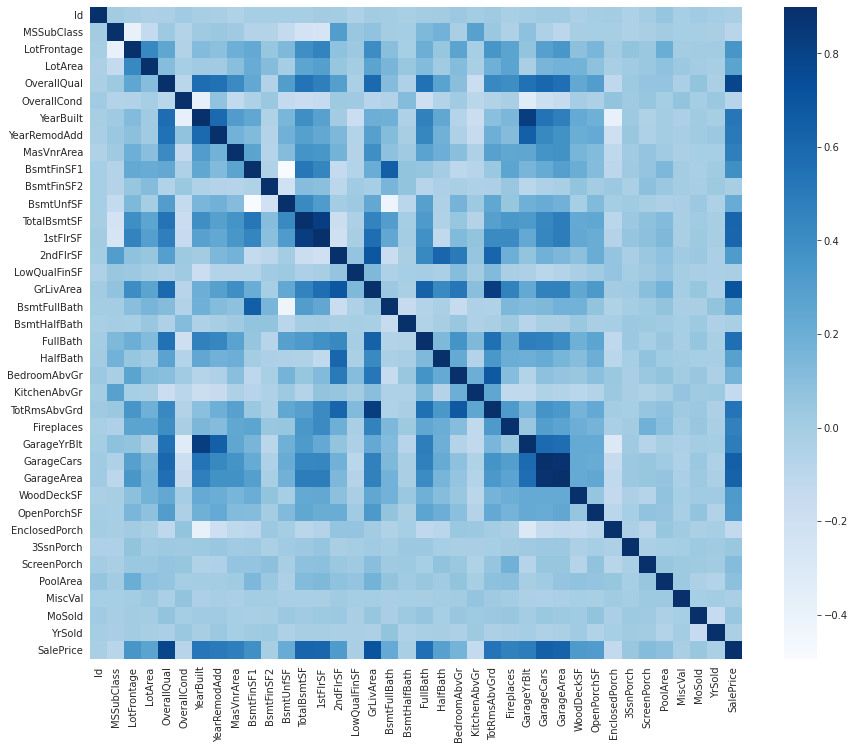

In [74]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

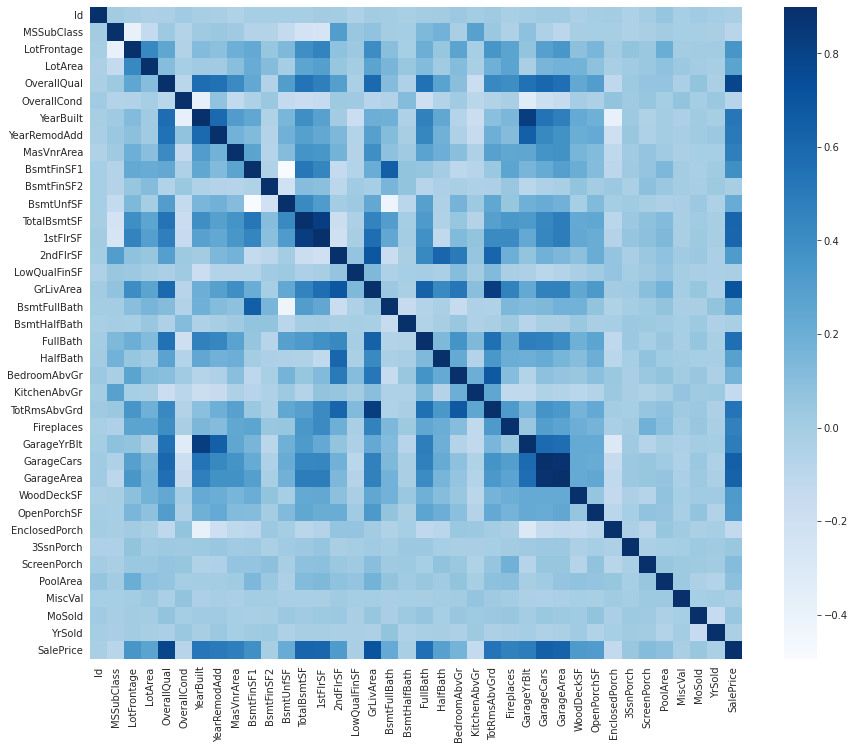

In [75]:
corr = train[numeric].corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [76]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
data

,SalePrice,OverallQual
0,208500,7
1,181500,6
2,223500,7
3,140000,7
4,250000,8
...,...,...
1455,175000,6
1456,210000,6
1457,266500,7
1458,142125,5


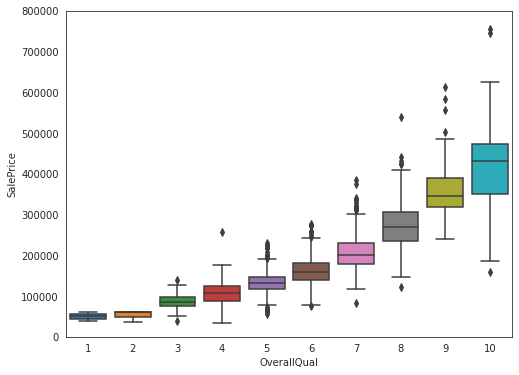

In [77]:
f, ax = plt.subplots(figsize=(8, 6))

# 원본
# fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

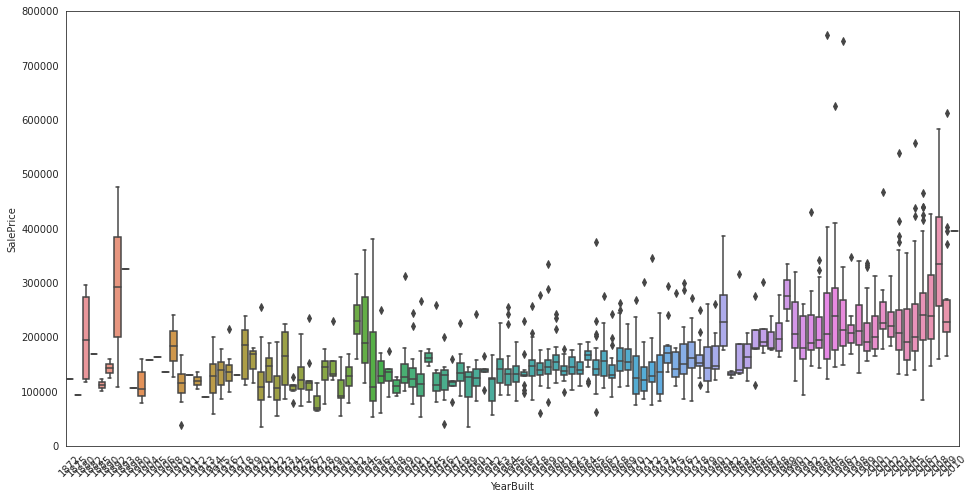

In [78]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
# fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);

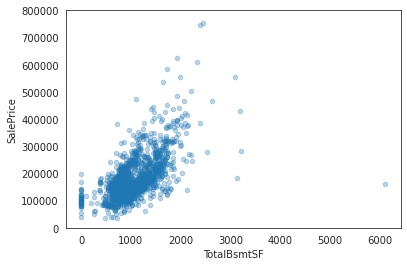

In [79]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)

# alpha : 색상의 투명도, 0 == 투명, 1 == 불투명
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

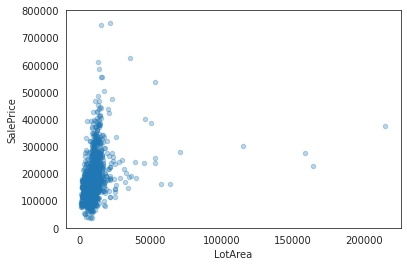

In [80]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

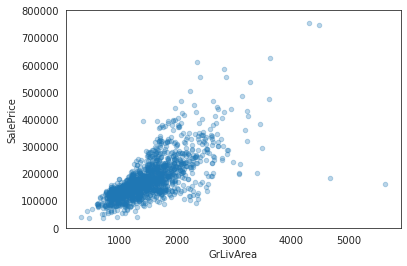

In [81]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

In [82]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

In [83]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Feature Engineering

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


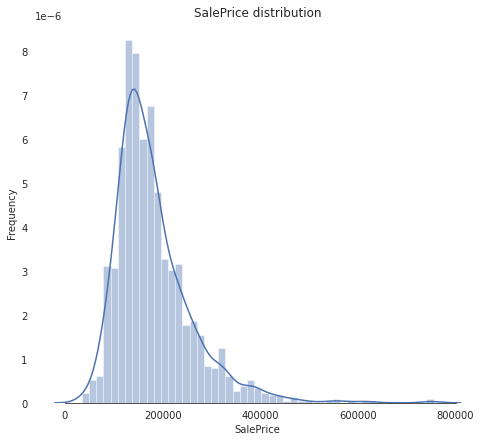

In [84]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [85]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



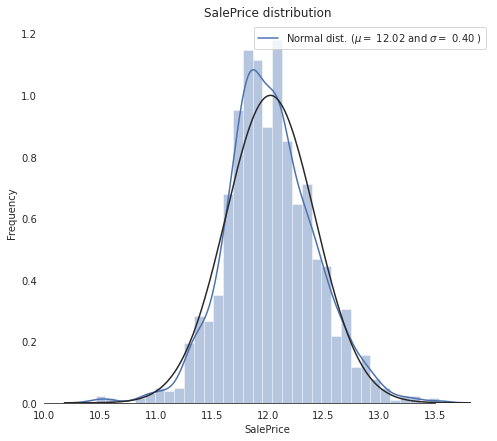

In [86]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [87]:
(mu, sigma) = norm.fit(train['SalePrice'])
print(mu)
print(sigma)

12.024057394918406
0.39931245219387496


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


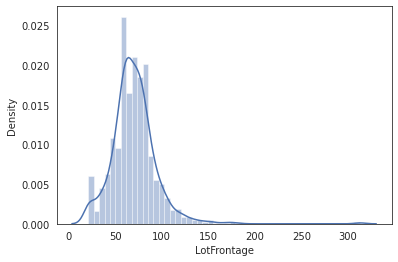

In [88]:
sns.distplot(train['LotFrontage'] , color="b");

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


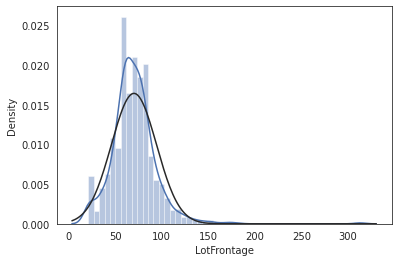

In [89]:
sns.distplot(train['LotFrontage'] , fit=norm, color="b");

### Remove Outliers

In [90]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


In [91]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [92]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1454,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1455,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1456,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


In [93]:
# Split features and labels
# y_train
train_labels = train['SalePrice'].reset_index(drop=True)

# x_train
train_features = train.drop(['SalePrice'], axis=1)

# x_test
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

In [94]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


### Fill missing values

In [95]:
print("총 데이터 개수 :", all_features["LotFrontage"].shape)
print("총 결측치 개수 :", all_features["LotFrontage"].isnull().sum())
print('-' * 30)
print(all_features["LotFrontage"].isnull().sum() / all_features["LotFrontage"].shape[0])
print(all_features["LotFrontage"].isnull().mean())

총 데이터 개수 : (2917,)
총 결측치 개수 : 486
------------------------------
0.16660953033938977
0.16660953033938977


In [96]:
def percent_missing(df):
    data = pd.DataFrame(df)

    # df의 columns 저장
    df_cols = list(pd.DataFrame(data))
    dict_x = {}

    # column을 하나씩 순회
    # 결측치의 비율에 100을 곱하고 소수 둘째까지 표현하고 기록
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
# 결측치 비율 기준 내림차순 정렬
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')

# 결측치 비율 상위 TOP10
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

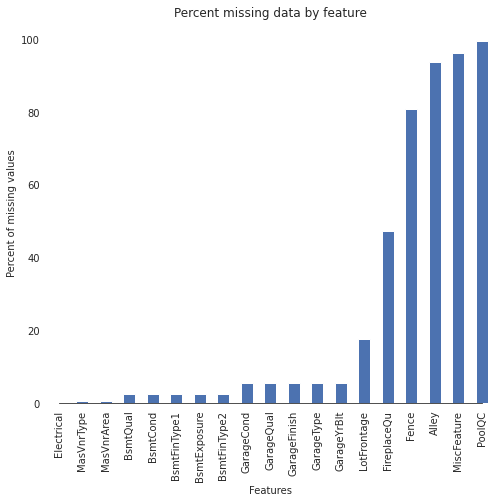

In [97]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

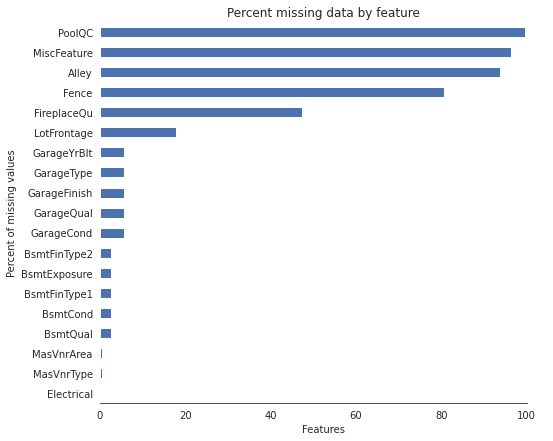

In [98]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.barh(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [99]:
all_features[['MSSubClass', 'YrSold', 'MoSold']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   MSSubClass  2917 non-null   int64
 1   YrSold      2917 non-null   int64
 2   MoSold      2917 non-null   int64
dtypes: int64(3)
memory usage: 68.5 KB


In [100]:
# int type이지면 범주형으로 사용되는 column들 str 타입으로 변경
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [101]:
all_features[['MSSubClass', 'YrSold', 'MoSold']].describe()

,MSSubClass,YrSold,MoSold
count,2917,2917,2917
unique,16,5,12
top,20,2007,6
freq,1079,691,503


In [102]:
for i in ['MSSubClass', 'YrSold', 'MoSold']:
    print(all_features[i].value_counts())
    print("-" * 30)

20     1079
60      573
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
------------------------------
2007    691
2009    647
2008    621
2006    619
2010    339
Name: YrSold, dtype: int64
------------------------------
6     503
7     446
5     394
4     279
8     233
3     232
10    172
9     158
11    142
2     133
1     121
12    104
Name: MoSold, dtype: int64
------------------------------


In [103]:
df_miss[:5]

[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68)]

In [104]:
dict(df_miss)

{'PoolQC': 99.69,
 'MiscFeature': 96.4,
 'Alley': 93.21,
 'Fence': 80.43,
 'FireplaceQu': 48.68,
 'LotFrontage': 16.66,
 'GarageYrBlt': 5.45,
 'GarageFinish': 5.45,
 'GarageQual': 5.45,
 'GarageCond': 5.45,
 'GarageType': 5.38,
 'BsmtCond': 2.81,
 'BsmtExposure': 2.81,
 'BsmtQual': 2.78,
 'BsmtFinType2': 2.74,
 'BsmtFinType1': 2.71,
 'MasVnrType': 0.82,
 'MasVnrArea': 0.79,
 'MSZoning': 0.14,
 'Utilities': 0.07,
 'BsmtFullBath': 0.07,
 'BsmtHalfBath': 0.07,
 'Functional': 0.07,
 'Exterior1st': 0.03,
 'Exterior2nd': 0.03,
 'BsmtFinSF1': 0.03,
 'BsmtFinSF2': 0.03,
 'BsmtUnfSF': 0.03,
 'TotalBsmtSF': 0.03,
 'Electrical': 0.03,
 'KitchenQual': 0.03,
 'GarageCars': 0.03,
 'GarageArea': 0.03,
 'SaleType': 0.03,
 'MSSubClass': 0.0,
 'LotArea': 0.0,
 'Street': 0.0,
 'LotShape': 0.0,
 'LandContour': 0.0,
 'LotConfig': 0.0,
 'LandSlope': 0.0,
 'Neighborhood': 0.0,
 'Condition1': 0.0,
 'Condition2': 0.0,
 'BldgType': 0.0,
 'HouseStyle': 0.0,
 'OverallQual': 0.0,
 'OverallCond': 0.0,
 'YearBuilt':

In [105]:
temp = pd.Series(dict(df_miss))
temp

PoolQC           99.69
MiscFeature      96.40
Alley            93.21
Fence            80.43
FireplaceQu      48.68
                 ...  
PoolArea          0.00
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SaleCondition     0.00
Length: 79, dtype: float64

In [106]:
# 최빈값으로 결측치 대체된 col의 결측치 비율
temp[['Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSZoning']]

Functional     0.07
Electrical     0.03
KitchenQual    0.03
Exterior1st    0.03
Exterior2nd    0.03
SaleType       0.03
MSZoning       0.14
dtype: float64

In [107]:
# 0 or None으로 결측치 대체된 col의 결측치 비율
temp[['PoolQC', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'GarageType', 'GarageFinish', 'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'BsmtExposure']]

PoolQC          99.69
GarageYrBlt      5.45
GarageArea       0.03
GarageCars       0.03
GarageType       5.38
GarageFinish     5.45
BsmtFinType1     2.71
BsmtQual         2.78
BsmtCond         2.81
BsmtExposure     2.81
dtype: float64

In [108]:
temp["LotFrontage"]

16.66

In [109]:
def handle_missing(features):
    # 범주형 데이터들 최빈값으로 결측치 대체
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # 결측치 None으로 대체
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # 결측치 0으로 대체
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # 결측치 None으로 대체
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # 결측치 None으로 대체
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # 결측치 중간값으로 대체
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # 범주형 데이터 None으로 결측치 대체
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # 수치형 데이터 결측치 0으로 대체
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    
    # 임의로 추가
    # 결측치 비율로 보아하니
    # 비율이 낮은 친구들만 최빈값으로 대체했나 했더니 그것도 아니다
    # 아마 작성자의 배경지식에 따라 col 선별 추측
    print(temp[objects])
    print(temp[numeric])
    return features

all_features = handle_missing(all_features)

MSSubClass        0.00
MSZoning          0.14
Street            0.00
Alley            93.21
LotShape          0.00
LandContour       0.00
Utilities         0.07
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.03
Exterior2nd       0.03
MasVnrType        0.82
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.78
BsmtCond          2.81
BsmtExposure      2.81
BsmtFinType1      2.71
BsmtFinType2      2.74
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.03
KitchenQual       0.03
Functional        0.07
FireplaceQu      48.68
GarageType        5.38
GarageFinish      5.45
GarageQual        5.45
GarageCond        5.45
PavedDrive        0.00
PoolQC           99.69
Fence            80.43
MiscFeature      96.40
MoSold            0.00
YrSold     

### 최빈값

In [110]:
all_features[["Functional", "Electrical", "KitchenQual"]].describe().loc["top", :]

Functional       Typ
Electrical     SBrkr
KitchenQual       TA
Name: top, dtype: object

In [111]:
all_features['Exterior2nd'].mode()

0    VinylSd
dtype: object

In [112]:
all_features[["Functional", "Electrical", "KitchenQual"]].mode()

,Functional,Electrical,KitchenQual
0,Typ,SBrkr,TA


### 결측치 대체 후 비율 확인

In [113]:
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

### Fix skewed features
* skew : 비대칭도, 왜도
* 양수면 오른쪽으로 긴 꼬리, 왼쪽에 데이터 분포
* 음수면 왼쪽으로 긴 꼬리, 오른쪽에 데이터 분포
* 평균과 중앙값이 같으면 왜도는 0

In [114]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

In [115]:
numeric

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

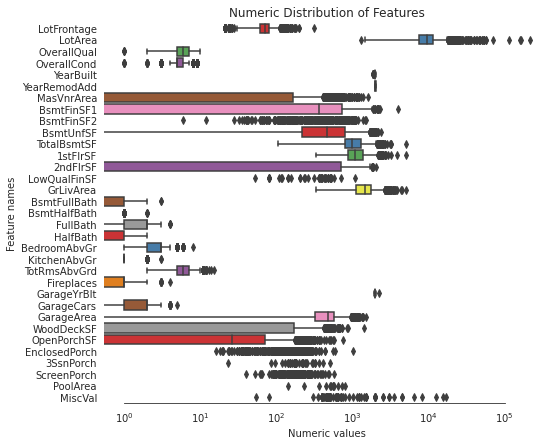

In [116]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [117]:
# 원본 코드
# 왜도 기준 내림차순 정렬
# skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

# high_skew = skew_features[skew_features > 0.5]
# skew_index = high_skew.index

# print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
# skewness = pd.DataFrame({'Skew' :high_skew})
# skew_features.head(10)

In [118]:
# 원본 코드가 에러나서 노트북의 결과물처럼 출력되도록 코드 구현
# 수치가 100% 일치하지 않음
# 0.002 ~ 0.01정도의 차이
skew_features = all_features[numeric].skew().sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.950962
PoolArea         17.697766
LotArea          13.116240
LowQualFinSF     12.090757
3SsnPorch        11.377932
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
ScreenPorch       3.947131
BsmtHalfBath      3.932018
dtype: float64

In [126]:
for i in skew_index:
    print(all_features[i].describe().loc['min'])

0.0
0.0
1300.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
334.0
21.0
334.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
1.0


In [59]:
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


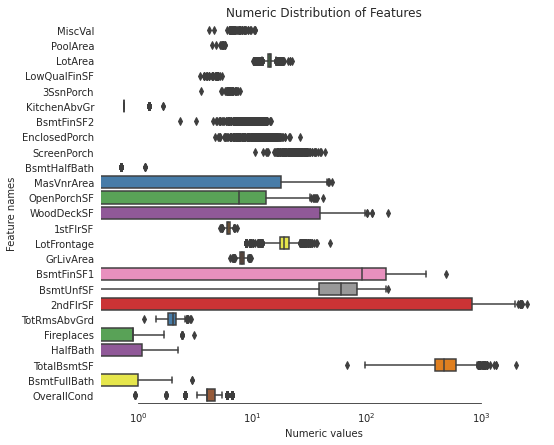

In [60]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

### Create interesting features

In [ ]:
# 파생 변수 생성
# True == 1
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
def logs(res, ls):
    # m : df column 개수
    m = res.shape[1]

    # col 하나씩 순회
    for l in ls:
        # col의 값에 += 1.01, log 변환 후 df에 추가
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   

        # "col_log" column 생성
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [ ]:
def squares(res, ls):
    # 열의 개수
    m = res.shape[1]

    # col 하나씩 순회
    for l in ls:
        # col의 값을 제곱
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        # "col_sq" 라는 이름으로 추가
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

### Encode categorical features

In [ ]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [ ]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144573,13.833054,7,3.991517,2003,2003,19.433175,144.117862,0.0,29.991055,...,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117918,6,6.000033,1976,1976,54.598150,181.719186,0.0,44.135415,...,0,0,0,1,0,0,0,0,1,0
2,18.668047,14.476512,7,3.991517,2001,2002,17.768840,110.441033,0.0,56.896536,...,0,0,0,1,0,0,0,0,1,0
3,17.249651,14.106196,7,3.991517,1915,1970,54.598150,61.795315,0.0,64.808858,...,0,0,0,1,1,0,0,0,0,0
4,21.314283,15.022008,8,3.991517,2000,2000,25.404164,136.624601,0.0,61.166379,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
# 중복하면 True
# 중복 column 제외
all_features = all_features.loc[:,~all_features.columns.duplicated()]
all_features.shape

(2917, 378)

### Recreate training and test sets

In [ ]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

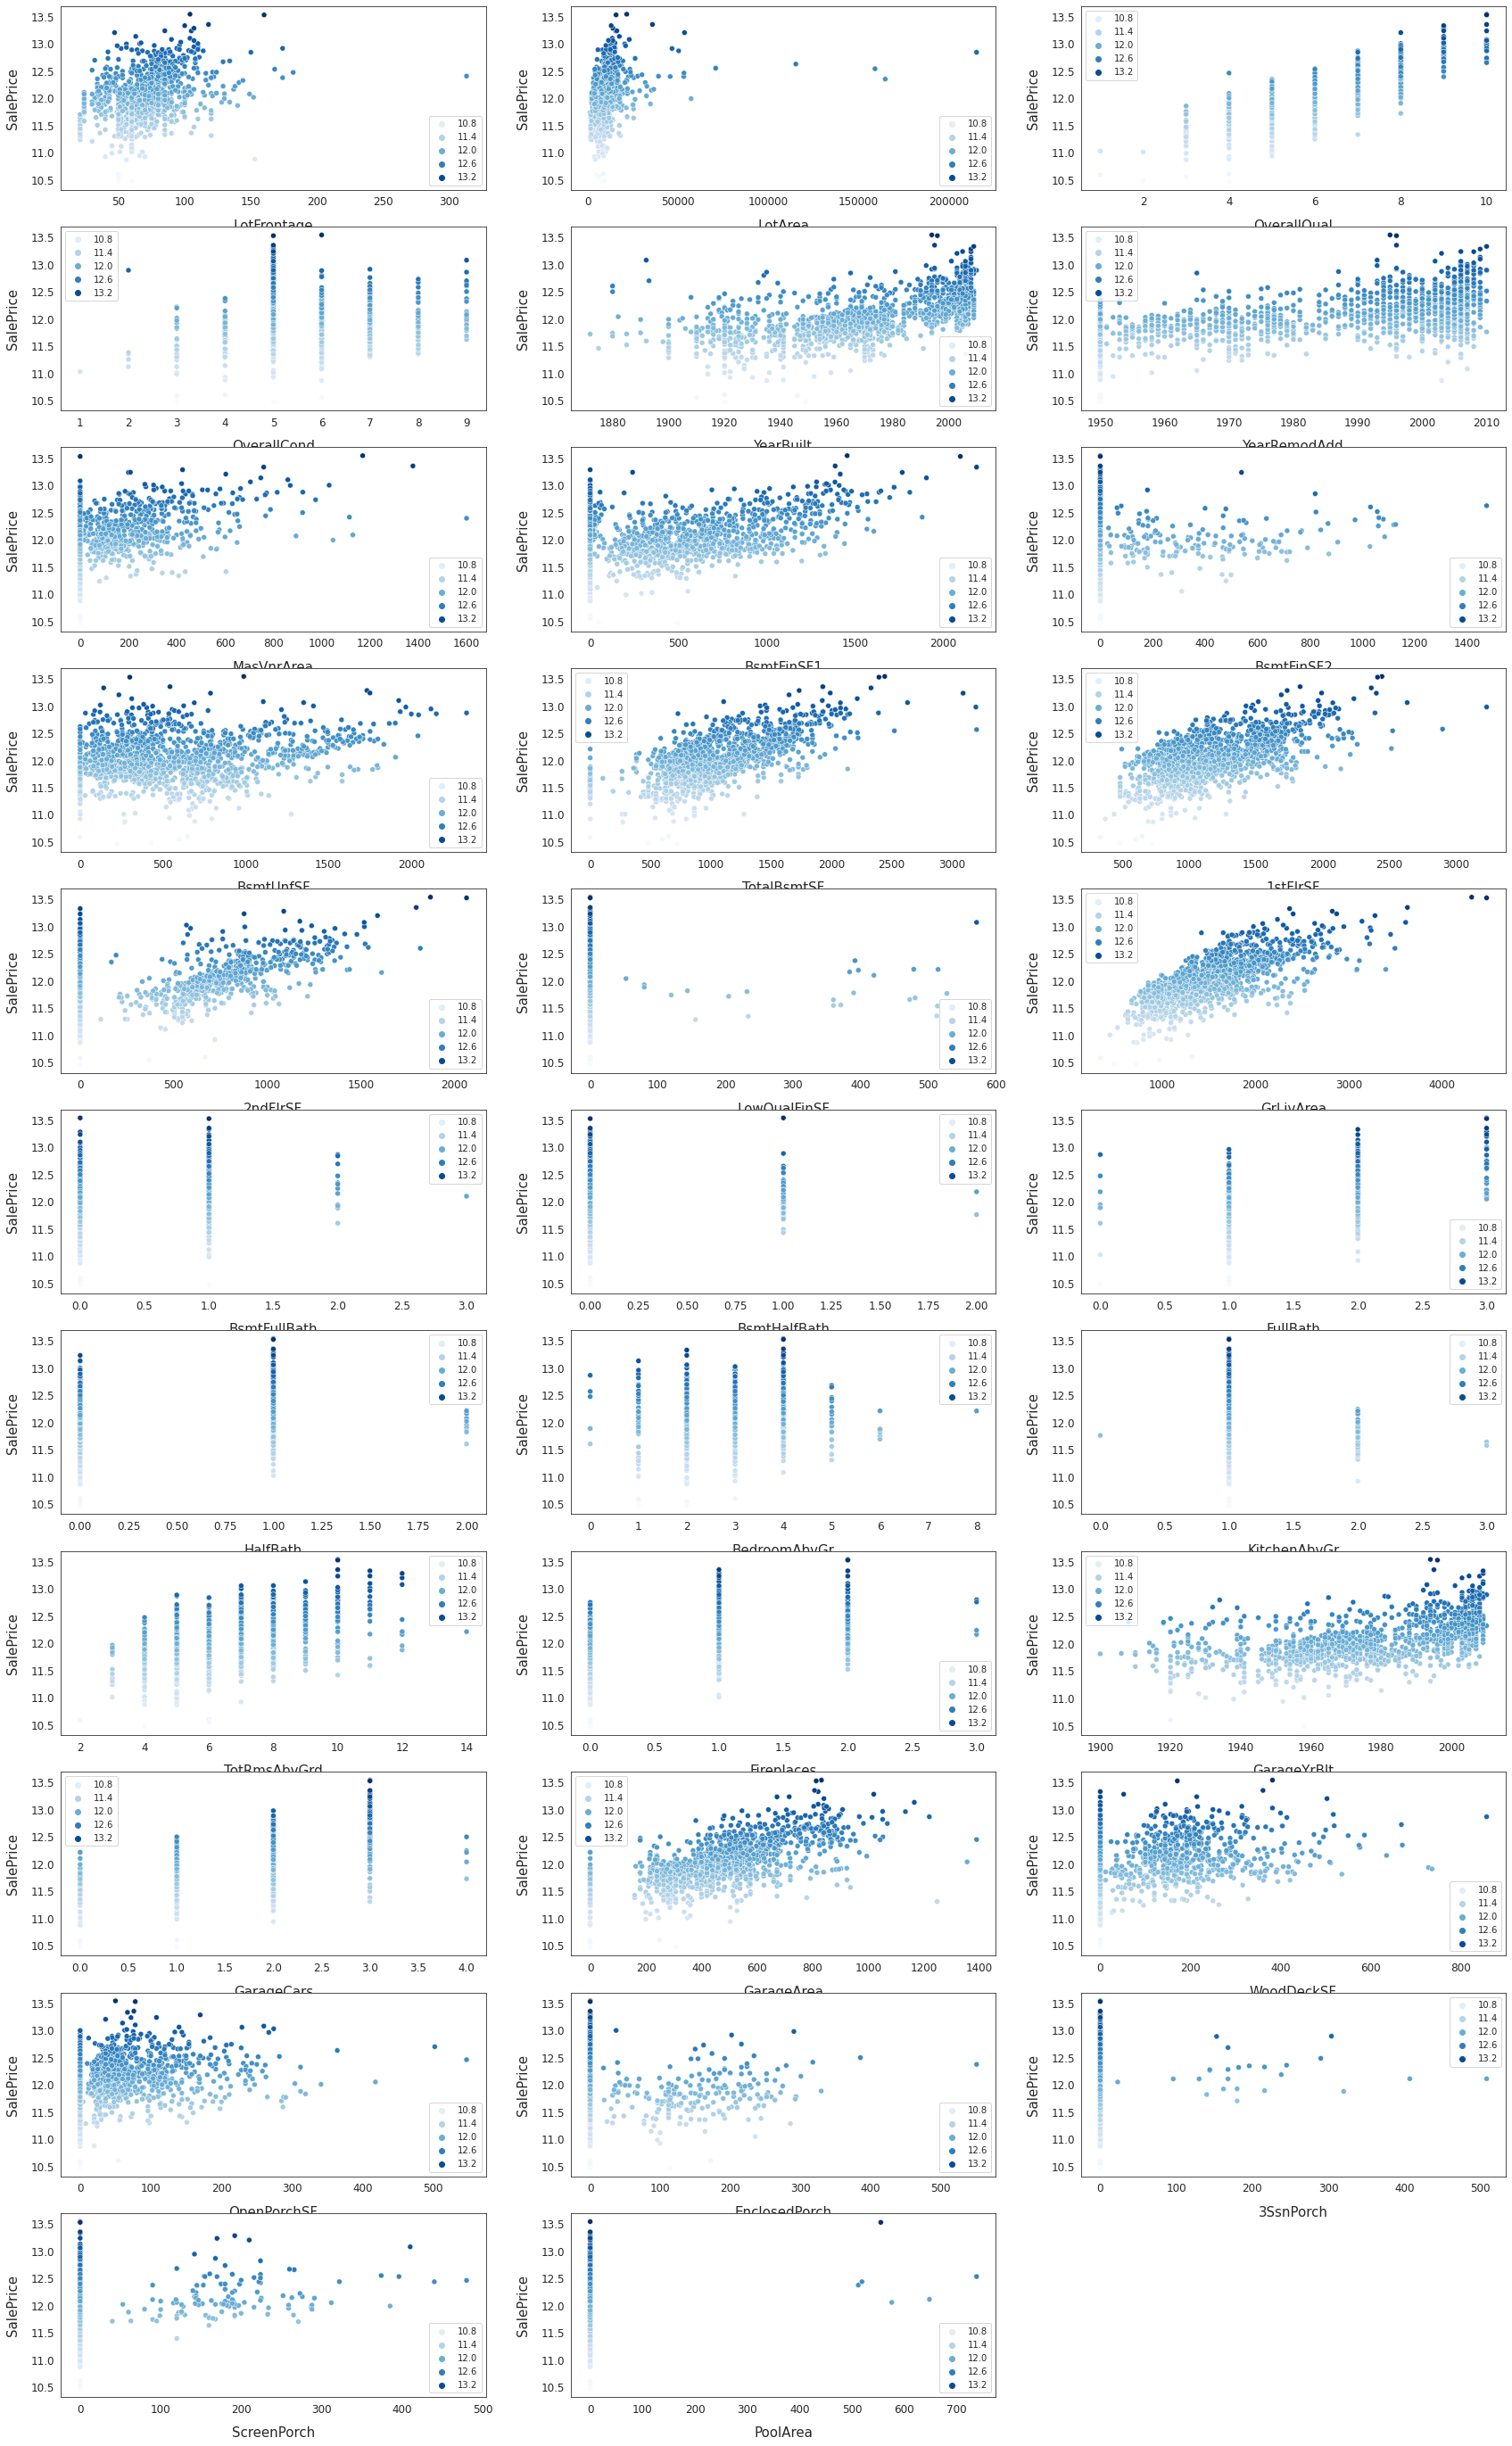

In [ ]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

## Train a model
* Cross Validation: Using 12-fold cross-validation
* Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
* Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
* Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

In [ ]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [ ]:
# 손실 함수
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [ ]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                    #    objective='reg:linear',
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost

# use_features_in_secondary
# If True, the meta-regressor will be trained both on the predictions of the original regressors and the original dataset. If False, the meta-regressor will be trained only on the predictions of the original regressors.
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                # The meta-regressor to be fitted on the ensemble of regressor
                                meta_regressor=xgboost,
                                # 원본 설정
                                # 차이가 이거 때문인지는 모르곘으나 
                                # True는 xgboost가 너무 오래 걸려서
                                # False로 진행
                                # use_features_in_secondary=True,
                                use_features_in_secondary=False)

In [ ]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1164 (0.0169)


#### cv_rmse 해부

In [ ]:
# rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
score

array([0.09240939, 0.14317756, 0.11477337, 0.11516308, 0.12706298,
       0.11557216, 0.11114253, 0.13783026, 0.13966033, 0.10710357,
       0.10396957, 0.08940944])

In [ ]:
# cross_val_score의 역할 각 cv마다의 정확도 예측, 높을수록 좋은 것
# 근데 회귀의 정확도가 왜 높지
cross_val_score(lightgbm, X, train_labels, cv=kf)

array([0.94330045, 0.89213735, 0.90990237, 0.90691391, 0.89661057,
       0.91305092, 0.9171945 , 0.90118739, 0.88912574, 0.92560194,
       0.92528614, 0.94248658])

In [ ]:
# scoring="neg_mean_squared_error"
# mse는 낮아야 좋은 것
# -mse로 계산 -> 커야 좋은 것으로 보기 위해

# 나중에 -1을 곱함으로써 mse로 변환
cross_val_score(lightgbm, X, train_labels, scoring="neg_mean_squared_error", cv=kf)

array([-0.0085395 , -0.02049981, -0.01317293, -0.01326254, -0.016145  ,
       -0.01335692, -0.01235266, -0.01899718, -0.01950501, -0.01147117,
       -0.01080967, -0.00799405])

In [ ]:
# mse로 바뀐 모습
-cross_val_score(lightgbm, X, train_labels, scoring="neg_mean_squared_error", cv=kf)

array([0.0085395 , 0.02049981, 0.01317293, 0.01326254, 0.016145  ,
       0.01335692, 0.01235266, 0.01899718, 0.01950501, 0.01147117,
       0.01080967, 0.00799405])

In [ ]:
# mse ** 0.5 = rmse
rmse = np.sqrt(-cross_val_score(lightgbm, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
rmse

array([0.09240939, 0.14317756, 0.11477337, 0.11516308, 0.12706298,
       0.11557216, 0.11114253, 0.13783026, 0.13966033, 0.10710357,
       0.10396957, 0.08940944])

### 돌아와서

In [ ]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1358 (0.0170)


In [ ]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1094 (0.0200)


In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1101 (0.0161)


In [ ]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1366 (0.0188)


In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1121 (0.0166)


### Fit the models

In [ ]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen


In [ ]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


### Blend models and get predictions

In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
# 모델별 예측값을 일정 비율로 혼합
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [ ]:
# 학습 데이터로 오차 계산
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.0756425910537096


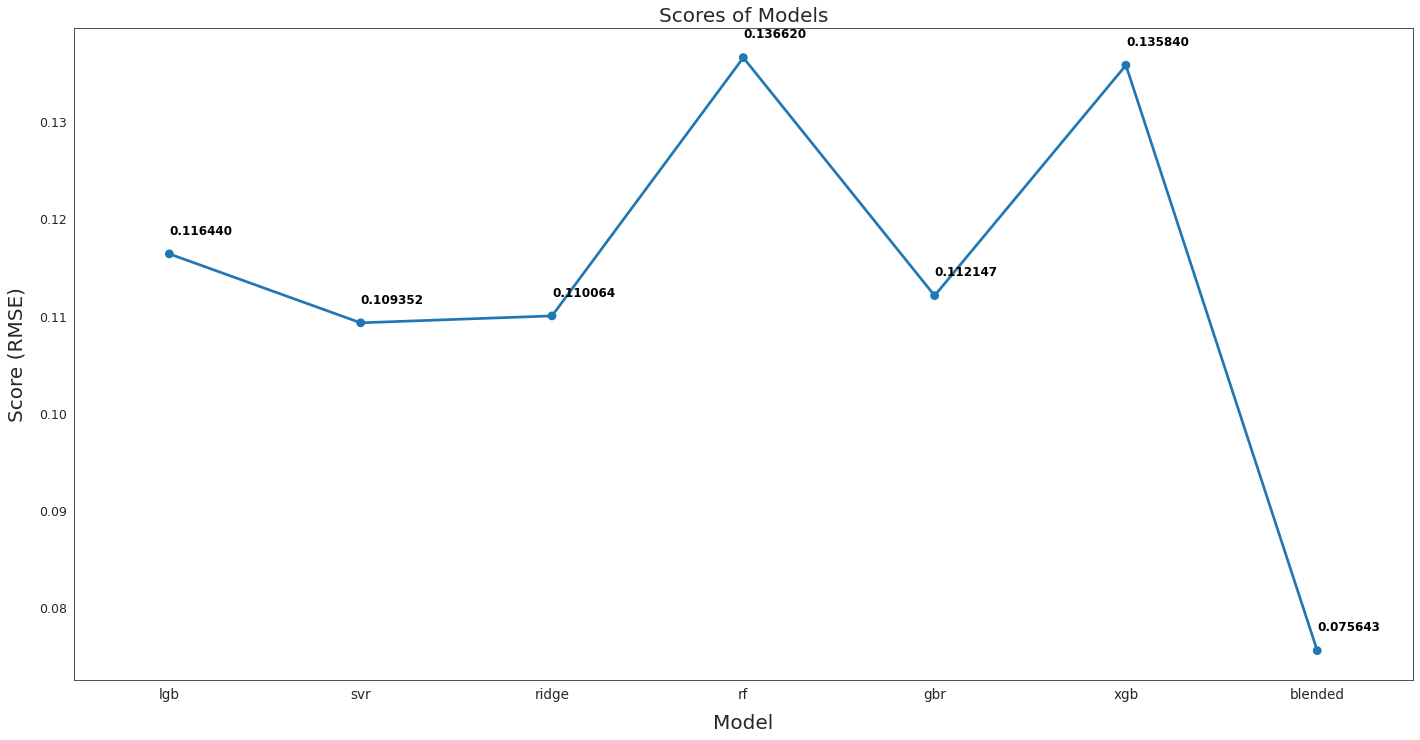

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## Submit

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

(1459, 2)

In [ ]:
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [ ]:
# np.floor : 내림
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [ ]:
submission

,Id,SalePrice
0,1461,122106.0
1,1462,160554.0
2,1463,184375.0
3,1464,195381.0
4,1465,188149.0
...,...,...
1454,2915,87969.0
1455,2916,84519.0
1456,2917,164587.0
1457,2918,113085.0


In [ ]:
submission['SalePrice'].describe()

count      1459.000000
mean     178079.335846
std       75145.906635
min       53444.000000
25%      128978.000000
50%      157689.000000
75%      208281.500000
max      623485.000000
Name: SalePrice, dtype: float64

In [ ]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

# q1 작으면 0.77을 곱하고 q2보다 크면 1.1을 곱해라
# 이상치를 더작고 더크게 만든다?
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
q1, q2

(57014.363, 450258.68000000005)

In [ ]:
# 평균, 표준편차 상승
submission['SalePrice'].describe()

count      1459.000000
mean     178518.083955
std       77450.492053
min       41151.880000
25%      128978.000000
50%      157689.000000
75%      208281.500000
max      685833.500000
Name: SalePrice, dtype: float64

In [ ]:
submission

,Id,SalePrice
0,1461,122106.0
1,1462,160554.0
2,1463,184375.0
3,1464,195381.0
4,1465,188149.0
...,...,...
1454,2915,87969.0
1455,2916,84519.0
1456,2917,164587.0
1457,2918,113085.0


In [ ]:
submission['SalePrice'] *= 1.001619

In [ ]:
submission

,Id,SalePrice
0,1461,122303.689614
1,1462,160813.936926
2,1463,184673.503125
3,1464,195697.321839
4,1465,188453.613231
...,...,...
1454,2915,88111.421811
1455,2916,84655.836261
1456,2917,164853.466353
1457,2918,113268.084615
